# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import torch
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
import time

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 100
num_samples_ouu = 10 if smoke_test else 100
maxiter = 0 if smoke_test else 1
maxfeval = 1 if smoke_test else 10

### Define QoI function

In [4]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

### Baseline samples before optimization from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.361320,18.023865,1.357174,0.064888,999.577881
1,1,0,2.0,0.361320,18.023865,1.841593,0.152944,999.005432
2,2,0,3.0,0.361320,18.023865,2.498314,0.272415,998.229309
3,3,0,4.0,0.361320,18.023865,3.388113,0.434464,997.177612
4,4,0,5.0,0.361320,18.023865,4.592789,0.654180,995.753113
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.386109,14.880690,403.469849,556.541138,40.989220
3896,35,99,36.0,0.386109,14.880690,382.818604,582.960205,35.222069
3897,36,99,37.0,0.386109,14.880690,362.493317,608.000366,30.506607
3898,37,99,38.0,0.386109,14.880690,342.681030,631.690979,26.627947


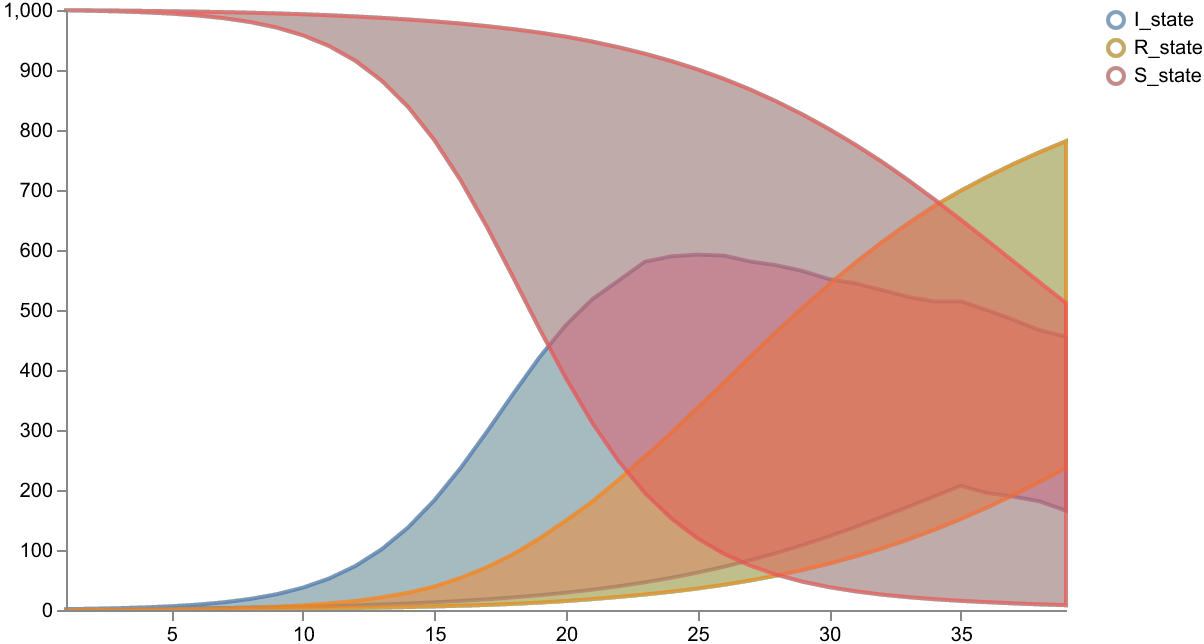

In [31]:
sample_results1 = pyciemss.sample(
    model_opt1, end_time, logging_step_size, num_samples, start_time=start_time
)
display(sample_results1["data"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2 using different ODE solvers

Time taken:  10.513278722763062


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.249310,0.477958,0.483950,0.167110,0.075883,6.405195,0.004808,35.061546,0.676154,11.288852,3.744379,19339992.0,11.288852,35.061546,0.676154,0.004808
1,1,0,2.0,0.249310,0.477958,0.483950,0.167110,0.075883,6.405195,0.021136,32.653839,1.479812,13.621075,9.021147,19339984.0,13.621075,32.653839,1.479812,0.021136
2,2,0,3.0,0.249310,0.477958,0.483950,0.167110,0.075883,6.405195,0.049575,31.463459,2.256846,14.726109,15.108250,19339978.0,14.726109,31.463459,2.256846,0.049575
3,3,0,4.0,0.249310,0.477958,0.483950,0.167110,0.075883,6.405195,0.089202,30.858656,2.949066,15.240900,21.643671,19339972.0,15.240900,30.858656,2.949066,0.089202
4,4,0,5.0,0.249310,0.477958,0.483950,0.167110,0.075883,6.405195,0.138581,30.535645,3.541533,15.471835,28.441254,19339964.0,15.471835,30.535645,3.541533,0.138581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.605071,0.570391,0.479842,0.022368,0.035817,12.944912,0.324997,99.809410,2.286047,48.961124,505.247772,19339384.0,48.961124,99.809410,2.286047,0.324997
3896,35,99,36.0,0.605071,0.570391,0.479842,0.022368,0.035817,12.944912,0.341619,102.827934,2.355357,50.441807,529.010254,19339354.0,50.441807,102.827934,2.355357,0.341619
3897,36,99,37.0,0.605071,0.570391,0.479842,0.022368,0.035817,12.944912,0.358746,105.937477,2.426732,51.967243,553.488831,19339290.0,51.967243,105.937477,2.426732,0.358746
3898,37,99,38.0,0.605071,0.570391,0.479842,0.022368,0.035817,12.944912,0.376393,109.141228,2.500237,53.538864,578.710449,19339296.0,53.538864,109.141228,2.500237,0.376393


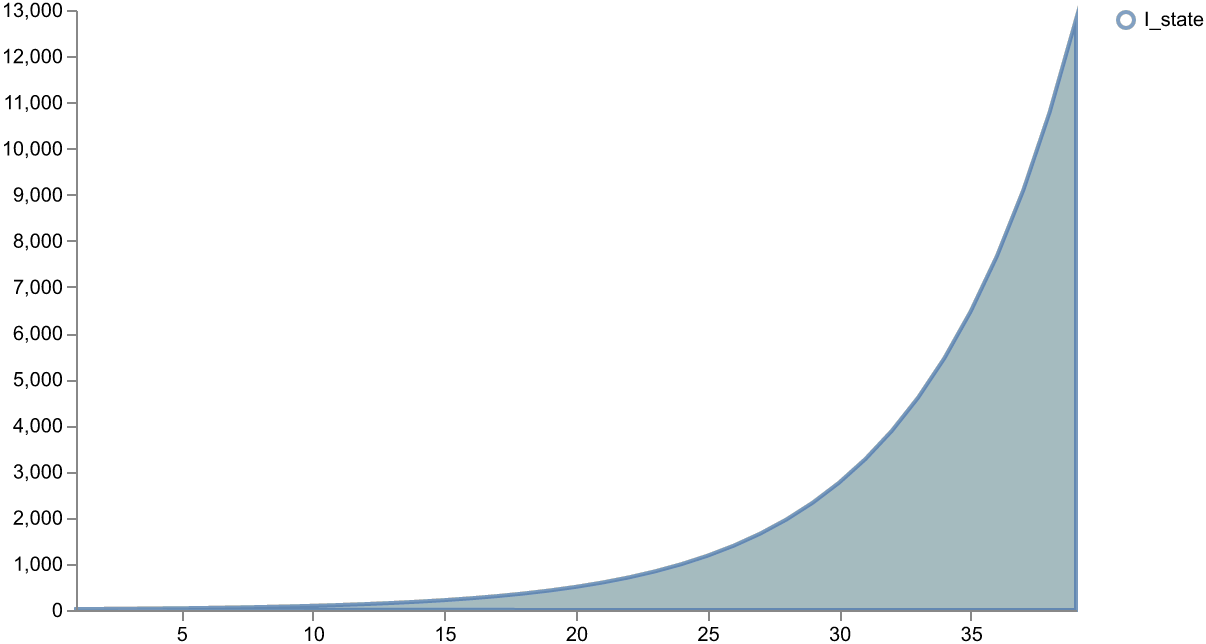

In [26]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="dopri5",
)
print("Time taken: ", time.time()-start_t)
display(sample_results2["data"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [15]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

#### Sample using optimal policy as intervention

In [24]:
result1 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="euler",
)
# display(result1["data"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

{1.0: {'p_cbeta': tensor([0.2237])}}


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.314054,19.060932,1.261276,0.052463,999.686279
1,1,0,2.0,0.314054,19.060932,1.476883,0.118634,999.404480
2,2,0,3.0,0.314054,19.060932,1.729253,0.196116,999.074646
3,3,0,4.0,0.314054,19.060932,2.024620,0.286839,998.688538
4,4,0,5.0,0.314054,19.060932,2.370264,0.393057,998.236694
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.390894,9.445127,48.182121,46.284496,906.533569
3896,35,99,36.0,0.390894,9.445127,52.842022,51.385765,896.772400
3897,36,99,37.0,0.390894,9.445127,57.837330,56.980400,886.182434
3898,37,99,38.0,0.390894,9.445127,63.167980,63.103909,874.728271


## Optimize interface for optimizing start time

In [32]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 1.
bounds_interventions = [[0.5], [39.5]]
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)











6it [00:46,  7.75s/it]

Optimal policy: tensor([4.], dtype=torch.float64)
{'policy': tensor([4.], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -4.0
                          x: [ 4.000e+00]
                        nit: 1
      minimization_failures: 2
                       nfev: 4
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -4.0
                                   x: [ 4.000e+00]
                                nfev: 2
                               maxcv: 0.0}


In [33]:
result2 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
)
# display(result2["data"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.349256,12.813910,1.270867,0.078040,999.651123
1,1,0,2.0,0.349256,12.813910,1.614947,0.177219,999.207886
2,2,0,3.0,0.349256,12.813910,2.051936,0.303250,998.644836
3,3,0,4.0,0.349256,12.813910,2.606766,0.463383,997.929871
4,4,0,5.0,0.349256,12.813910,2.232644,0.474755,998.292603
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.313551,17.372927,29.385365,17.954084,953.660400
3896,35,99,36.0,0.313551,17.372927,31.893269,19.645531,949.461060
3897,36,99,37.0,0.313551,17.372927,34.595139,21.481333,944.923401
3898,37,99,38.0,0.313551,17.372927,37.502380,23.472658,940.024841


## Optimize for start times of multiple interventions (SEIRHD)

In [23]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(5.), torch.tensor(5.)]
bounds_interventions = [[10., 10.], [35., 35.]]
intervention_value = torch.tensor([0.15, 0.35])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 2000.
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="euler",
    solver_options={"step_size": 0.1},
)
print(f'Optimal policy:', opt_result3["policy"])
print(opt_result3)

print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))

NameError: name 'num_samples_ouu' is not defined

Time taken:  8.19417405128479


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.005790,35.812138,0.629191,13.241706,3.086475e+00,19339986.0,13.241706,35.812138,0.629191,0.005790
1,1,0,2.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.023399,34.249908,1.389908,16.789696,7.463374e+00,19339980.0,16.789696,34.249908,1.389908,0.023399
2,2,0,3.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.053980,34.177589,2.177957,19.212952,1.274802e+01,19339970.0,19.212952,34.177589,2.177957,0.053980
3,3,0,4.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.097523,34.962692,2.944097,21.042341,1.872584e+01,19339960.0,21.042341,34.962692,2.944097,0.097523
4,4,0,5.0,0.150000,0.468834,0.350000,0.187064,0.086471,7.620363,0.154730,36.291584,3.663729,22.557556,2.533261e+01,19339950.0,22.557556,36.291584,3.663729,0.154730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,77022.390625,677628.625000,275797.750000,809046.000000,7.450660e+06,10049882.0,809046.000000,677628.625000,275797.750000,77022.390625
9896,95,99,96.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,81753.476562,567187.187500,261043.046875,700175.187500,7.725225e+06,10004652.0,700175.187500,567187.187500,261043.046875,81753.476562
9897,96,99,97.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,86217.148438,474973.343750,244174.218750,601874.500000,7.967242e+06,9965555.0,601874.500000,474973.343750,244174.218750,86217.148438
9898,97,99,98.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,90333.523438,399840.031250,225935.484375,516264.781250,8.174934e+06,9932728.0,516264.781250,399840.031250,225935.484375,90333.523438


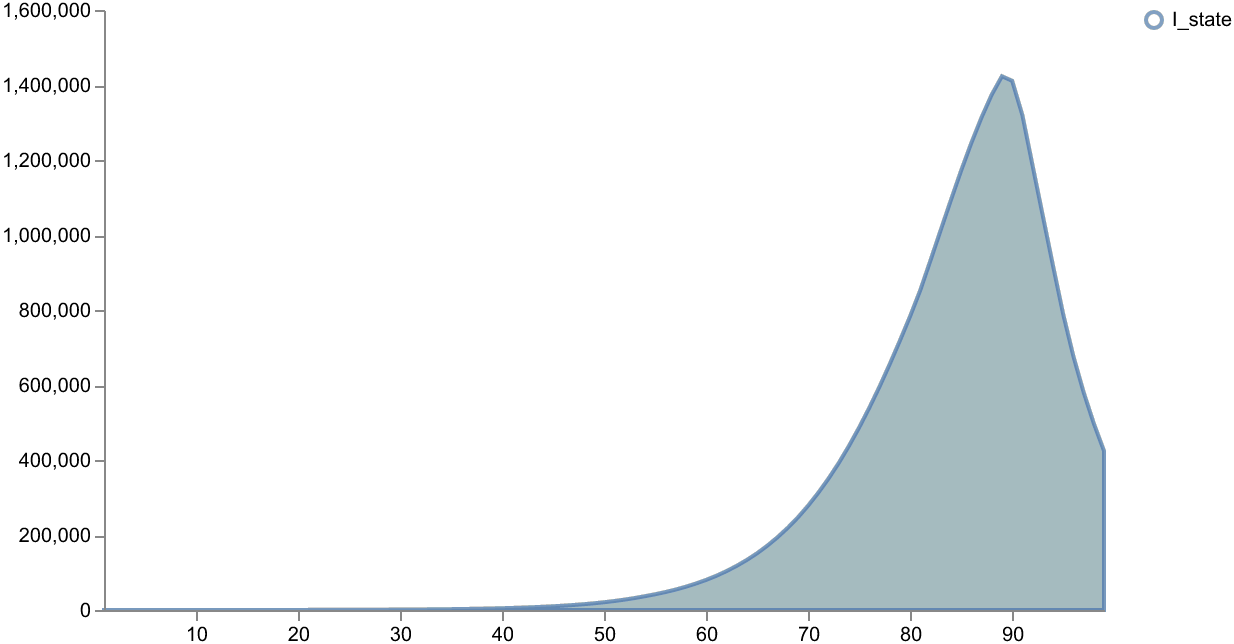

In [ ]:
import time
start_t = time.time()
result3 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
    solver_method="rk4",
    # solver_method="euler",
    solver_options={"step_size": 0.8},
)
print("Time taken: ", time.time()-start_t)
display(result3["data"])
# Plot results for all states
# schema = plots.trajectories(result3["data"], keep=".*_state")
# plots.ipy_display(schema, dpi=150)
schema = plots.trajectories(result3["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)

Time taken:  8.754577875137329


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.000401,35.022633,0.347615,15.055376,2.281618,19339988.0,15.055376,35.022633,0.347615,0.000401
1,1,0,2.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.002079,33.224503,0.807116,19.599751,5.804692,19339978.0,19.599751,33.224503,0.807116,0.002079
2,2,0,3.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.005284,33.259682,1.304054,22.958223,10.228070,19339968.0,22.958223,33.259682,1.304054,0.005284
3,3,0,4.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.010082,34.387726,1.803558,25.722313,15.370486,19339958.0,25.722313,34.387726,1.803558,0.010082
4,4,0,5.0,0.150000,0.395880,0.350000,0.141744,0.015949,8.265465,0.016462,36.204086,2.291641,28.224468,21.141350,19339948.0,28.224468,36.204086,2.291641,0.016462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.208786,1096.966431,312.458801,1281.773193,18390.800781,19318934.0,1281.773193,1096.966431,312.458801,19.208786
9896,95,99,96.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.917933,926.298035,295.937378,1113.679565,18831.251953,19318848.0,1113.679565,926.298035,295.937378,19.917933
9897,96,99,97.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,20.586340,783.916748,276.983704,962.387268,19217.660156,19318774.0,962.387268,783.916748,276.983704,20.586340
9898,97,99,98.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,21.209364,664.521973,256.629974,828.412659,19554.992188,19318710.0,828.412659,664.521973,256.629974,21.209364


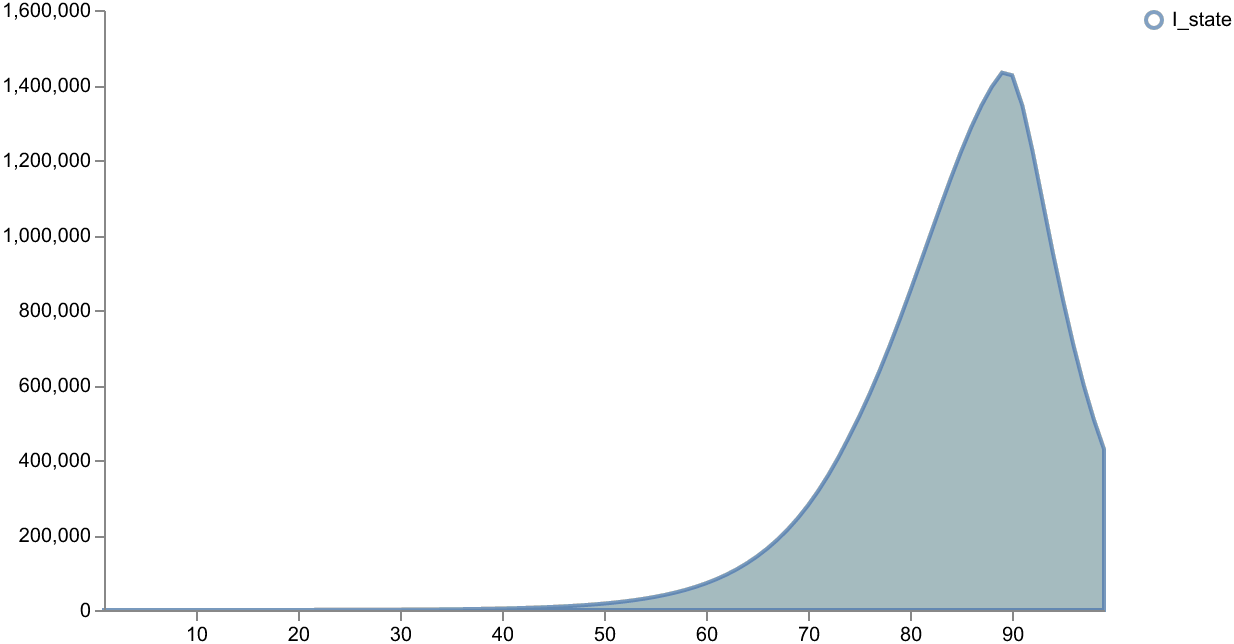

In [ ]:
start_t = time.time()
result3 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
    solver_method="euler",
    solver_options={"step_size": 0.2},
)
print("Time taken: ", time.time()-start_t)
display(result3["data"])
# Plot results for all states
# schema = plots.trajectories(result3["data"], keep=".*_state")
# plots.ipy_display(schema, dpi=150)
schema = plots.trajectories(result3["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)

Time taken:  16.12155294418335


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.006537,35.195354,0.838740,15.583101,4.126128,19339988.0,15.583101,35.195354,0.838740,0.006537
1,1,0,2.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.027022,32.389149,1.720320,17.855694,9.369328,19339978.0,17.855694,32.389149,1.720320,0.027022
2,2,0,3.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.061201,30.680210,2.541366,18.979063,15.257811,19339972.0,18.979063,30.680210,2.541366,0.061201
3,3,0,4.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.107720,29.574734,3.260566,19.474323,21.519539,19339978.0,19.474323,29.574734,3.260566,0.107720
4,4,0,5.0,0.150000,0.333112,0.350000,0.185165,0.079923,11.210128,0.164840,28.802074,3.867827,19.627031,27.994497,19339960.0,19.627031,28.802074,3.867827,0.164840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.584401,18.269659,2.709901,22.405989,894.369629,19339110.0,22.405989,18.269659,2.709901,0.584401
9896,95,99,96.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.592176,15.260543,2.527707,19.297033,901.831299,19339110.0,19.297033,15.260543,2.527707,0.592176
9897,96,99,97.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.599391,12.771304,2.334918,16.531406,908.276794,19339110.0,16.531406,12.771304,2.334918,0.599391
9898,97,99,98.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.606029,10.704046,2.138563,14.106043,913.817993,19339110.0,14.106043,10.704046,2.138563,0.606029


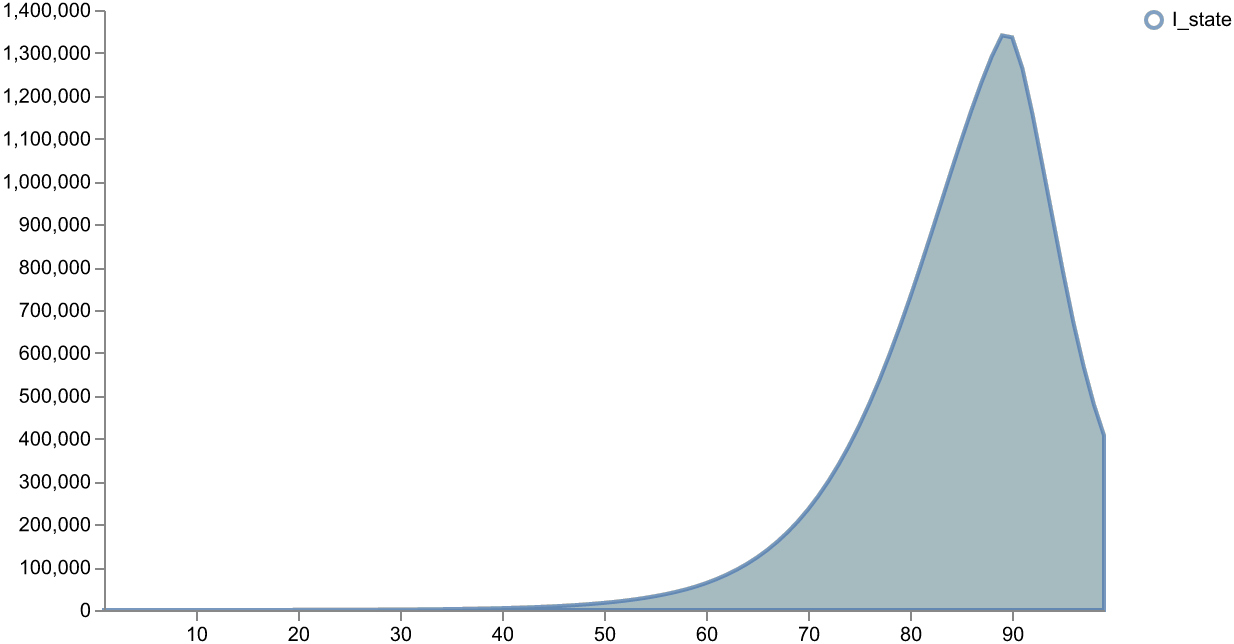

In [ ]:
start_t = time.time()
result3 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
    solver_method="dopri5",
)
print("Time taken: ", time.time()-start_t)
display(result3["data"])
# Plot results for all states
# schema = plots.trajectories(result3["data"], keep=".*_state")
# plots.ipy_display(schema, dpi=150)
schema = plots.trajectories(result3["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)